In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from LDA import LDA

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.models import CoherenceModel
import gensim.corpora as corpora

import re

import time, timeit


import pyLDAvis

In [2]:
seed = 17

# Датасет

URL: https://www.kaggle.com/datasets/jacopoferretti/bbc-articles-dataset

Датасет содержит 2225 статей с новостного сайта BBC за 2004-2005г. , разделенных на 5 тематических областей

In [3]:
data = pd.read_csv('./data/bbc_text_cls',sep=',')

In [4]:
data.sample(10)

,text,labels
1292,Blunkett hints at election call\n\nEx-Home Sec...,politics
2133,Latest Opera browser gets vocal\n\nNet browser...,tech
309,Strong quarterly growth for Nike\n\nNike has r...,business
983,Campaign 'cold calls' questioned\n\nLabour and...,politics
1106,Top judge clashes with ministers\n\nThe UK's t...,politics
285,China continues breakneck growth\n\nChina's ec...,business
1985,Microsoft gets the blogging bug\n\nSoftware gi...,tech
2043,Britons growing 'digitally obese'\n\nGadget lo...,tech
988,Kennedy calls for Iraq exit plans\n\nTony Blai...,politics
1417,Newcastle 2-1 Bolton\n\nKieron Dyer smashed ho...,sport


In [5]:
data.shape

(2225, 2)

In [6]:
data.labels.value_counts()

labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='labels'>

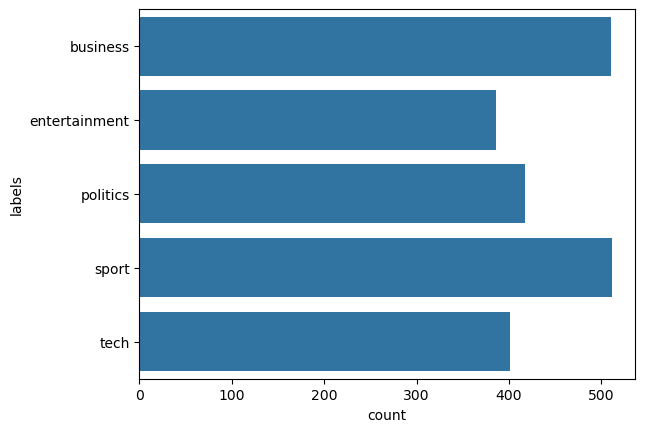

In [7]:
sns.countplot(data.labels)

# Предобработка текстов

Скачиваем необходимое

In [8]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
stop_words.add('said')
stop_words.add('year')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danil.tereshin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/danil.tereshin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danil.tereshin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/danil.tereshin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
sample_text = data.text.iloc[12]
sample_text[:120]

'Peugeot deal boosts Mitsubishi\n\nStruggling Japanese car maker Mitsubishi Motors has struck a deal to supply French car m'

In [10]:
lemmatizer.lemmatize('leaves')

'leaf'

In [11]:
nltk.word_tokenize('This is the test string')

['This', 'is', 'the', 'test', 'string']

In [12]:
def preprocess_text(text):
    # Удаление знаков переноса строки
    text = re.sub(r'\n', ' ', text)
    # Удаление специальных символов и цифр
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    text = text.lower()
    text = text.strip()
    
    # Токенизация
    tokens = nltk.word_tokenize(text)
    # Удаляем слова меньше 3 символов
    tokens = [word for word in tokens if len(word) >=3]
    # Лемматизация
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

In [13]:
data['processed_text'] = data['text'].apply(preprocess_text)

In [14]:
data.sample(5)

,text,labels,processed_text
13,Telegraph newspapers axe 90 jobs\n\nThe Daily ...,business,telegraph newspaper axe job daily sunday teleg...
1652,Castaignede fires Laporte warning\n\nFormer Fr...,sport,castaignede fire laporte warning former france...
53,Hyundai to build new India plant\n\nSouth Kore...,business,hyundai build new india plant south korea hyun...
809,Bollywood draws global stars\n\nBritish actres...,entertainment,bollywood draw global star british actress ant...
1500,Campbell lifts lid on United feud\n\nArsenal's...,sport,campbell lift lid united feud arsenal sol camp...


In [15]:
data.processed_text.iloc[12]

'peugeot deal boost mitsubishi struggling japanese car maker mitsubishi motor struck deal supply french car maker peugeot sport utility vehicle suv two firm signed memorandum understanding say expect seal final agreement spring alliance come badly needed boost loss making mitsubishi several profit warning poor sale suv built japan using peugeot diesel engine sold mainly european market falling sale left mitsubishi motor underused capacity production deal peugeot give chance utilise january mitsubishi motor issued third profit warning nine month cut sale forecast march sale slid past catalysed revelation company systematically hiding record fault secretly repairing vehicle result japanese car maker sought series financial bailouts last month looking yen fresh financial backing half company mitsubishi group german carmaker daimlerchrylser shareholder mitsubishi motor decided april pump money deal peugeot celebrated mitsubishi newly appointed chief executive takashi nishioka took three to

In [16]:
vectorizer = CountVectorizer(
    max_df=0.95,
    stop_words='english',
    analyzer='word',
    min_df=3,
    # биграммы, триграммы
    # ngram_range=(2,3)
)

data_vectorized = vectorizer.fit_transform(data['processed_text'])

In [17]:
data_vectorized.shape

(2225, 10903)

In [19]:
n_components = data.labels.nunique() # 5

no_top_words = 10
tf_feature_names = vectorizer.get_feature_names_out()

In [20]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [21]:
# https://stackoverflow.com/questions/60613532/how-do-i-calculate-the-coherence-score-of-an-sklearn-lda-model

def get_cogerence(model, texts, n_top_words=20):
    """ Получение когерентности """

    # Распределения слов по темам
    topics = model.components_

    # получение токенов
    texts = [[word for word in doc.split()] for doc in texts]
    # создание словаря с использованием gensim
    dictionary = corpora.Dictionary(texts)

    # Корпус на основе матрицы подсчета слов
    corpus = [dictionary.doc2bow(text) for text in texts]

    feature_names = [dictionary[i] for i in range(len(dictionary))]

    # Получение топ-слов для каждой темы
    top_words = []
    for topic in topics:
        top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

    coherence_model = CoherenceModel(topics=top_words,
                                     texts=texts,
                                     dictionary=dictionary,
                                     coherence='c_v')
    
    coherence = coherence_model.get_coherence()
    return coherence

# Обучение
## Своя реализация

In [22]:
lda_custom = LDA(n_components=n_components,
                max_iter = 10,
                alpha = 1 / n_components, # 1 / n_components
                beta = 1 / n_components, # 1 / n_components
                random_state = seed)

In [24]:
%timeit 
lda_custom.fit(data_vectorized)

13.3 s ± 169 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
lda_custom.transform(data_vectorized)[0]

array([0.02162629, 0.02496902, 0.12689124, 0.82550642, 0.00100703])

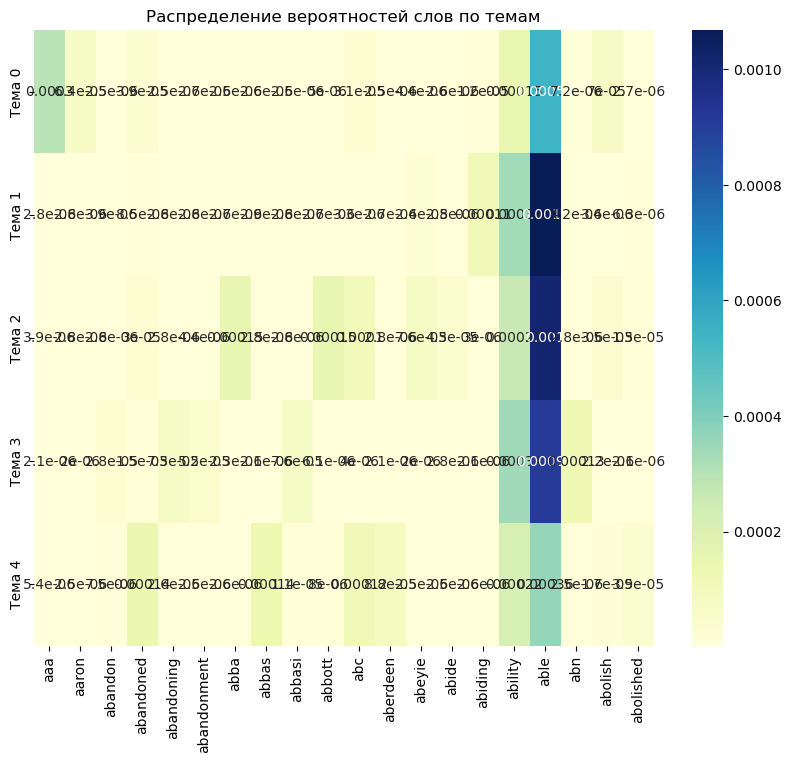

In [31]:
df = pd.DataFrame(lda_custom.components_[:,:20],
                  columns=tf_feature_names[:20],
                  index=[f"Тема {i}" for i in range(lda_custom.n_components)])

plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap="YlGnBu")
plt.title("Распределение вероятностей слов по темам")
plt.show()

In [33]:
np.argmax(lda_custom.components_,axis=1)

array([6519, 7063, 7063, 5981, 3696])

In [34]:
display_topics(lda_custom, tf_feature_names, no_top_words)
# lda_custom.get_topics(tf_feature_names)

Topic 0:
new time party win game election player world england wale
Topic 1:
people new game service time net user security software computer
Topic 2:
people music film best time new like make award number
Topic 3:
market company firm sale mobile people phone new tax price
Topic 4:
film best blair labour minister award brown star government world


In [35]:
get_cogerence(model=lda_custom,
                texts=list(data.processed_text))

0.746795238133307

## Библиотечная реализация

In [37]:
lda_model = LatentDirichletAllocation(
        learning_method='batch', # За одну итерацию обрабатываем весь корпус документов
        n_components=n_components, 
        max_iter = 10,
        n_jobs=None,
        random_state=seed
)

In [40]:
%timeit 
lda_model.fit(data_vectorized)

LatentDirichletAllocation(n_components=5, random_state=17)

In [41]:
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
film best award game star music new number actor song
Topic 1:
government labour election minister new party say blair tax plan
Topic 2:
game time win england player world club team final match
Topic 3:
people world music new say time like game broadband million
Topic 4:
people mobile phone firm company technology service user use new


In [44]:
lda_model.transform(data_vectorized[-10])[0]

array([0.00117471, 0.00118366, 0.00117438, 0.99527293, 0.00119432])

In [45]:
lda_model.components_

array([[ 2.67511016,  0.20121459,  0.20007772, ...,  1.62911531,
         0.20008584,  0.20181814],
       [ 0.20236484,  0.20004775,  1.35885008, ..., 10.44499621,
         0.20000008,  3.64441388],
       [21.68830773,  5.19833573,  0.20010411, ...,  5.95681191,
         0.20010879, 10.04873665],
       [ 0.21252882,  0.20000029,  0.20115013, ...,  5.47527952,
         0.20059972,  0.89063463],
       [ 0.22168845,  0.20040165,  2.03981797, ...,  2.49379704,
         5.19920557,  0.21439671]])

In [49]:
get_cogerence(model=lda_model,
                texts=list(data.processed_text))

0.7430538688721695

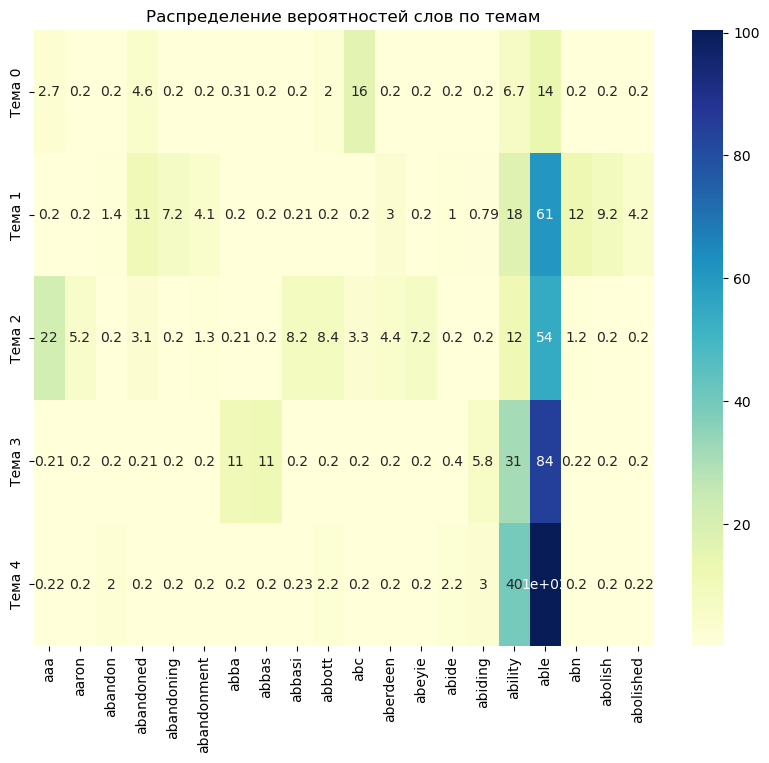

In [50]:
df = pd.DataFrame(lda_model.components_[:,:20], columns=tf_feature_names[:20], index=[f"Тема {i}" for i in range(lda_model.n_components)])

plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap="YlGnBu")
plt.title("Распределение вероятностей слов по темам")
plt.show()